In [2]:
# Adverse Events Case Study

# Contents

# Section 1: Functions and Classes to support the analysis
# Section 2: Compare adverse event reporting between all countries
# Section 3: Focus on adverse event reporting for 5 key countries
# Section 4: Compare adverse event reporting between 5 key countries
# Section 5: Compare adverse event reporting between 5 key countries for the drug Simvastatin
# Section 6: Compare adverse event reporting between 5 key countries for the drug Paracetamol (Acetaminophen)

In [ ]:
# Import modules
import json
import zipfile
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [ ]:
# Section 1: Functions and Classes to support the analysis

# i. Getting Data from the Drug Adverse Events API
def get_results_from_url(url):
    response = urllib.request.urlopen(url)
    response_json = json.loads(response.read().decode("utf-8"))
    return response_json['results']

def convert_results_json_to_table(results_json, term_name='term'):
    record_count = [record['count'] for record in results_json]
    record_country = [record['term'] for record in results_json]
    n_record_by_country = pd.DataFrame({term_name: record_country, 'count': record_count})
    return n_record_by_country

def get_n_records_per_adverse_event_for_all_countries(term_name='country'):
    url = 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]&count=primarysource.reportercountry.exact'
    print('Query url: {}'.format(url))
    results_json = get_results_from_url(url)
    n_record_by_country = convert_results_json_to_table(results_json, term_name)
    n_record_by_country['count_proportion'] = n_record_by_country['count'] / n_record_by_country['count'].sum()
    return n_record_by_country

def get_n_records_per_adverse_event_for_country(country_id):
    url = 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"{}"&count=patient.reaction.reactionmeddrapt.exact'.format(country_id)
    print('Query url: {}'.format(url))
    results_json = get_results_from_url(url)
    n_record_by_country = convert_results_json_to_table(results_json, 'adverse_event')
    country_col_name = '{}_{}'.format('count_proportion', country_id)
    n_record_by_country[country_col_name] = n_record_by_country['count'] / n_record_by_country['count'].sum()
    return n_record_by_country

def get_n_records_per_adverse_event_for_country_and_drug(country_id, drug):
    url = 'https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:{}+AND+primarysource.reportercountry.exact:"{}"&count=patient.reaction.reactionmeddrapt.exact'.format(drug, country_id)
    print('Query url: {}'.format(url))
    results_json = get_results_from_url(url)
    n_record_by_country = convert_results_json_to_table(results_json, 'adverse_event')
    country_col_name = '{}_{}'.format('count_proportion', country_id)
    n_record_by_country[country_col_name] = n_record_by_country['count'] / n_record_by_country['count'].sum()
    return n_record_by_country


# ii. Plotting
class AdverseEventsByCountryPairsPlot(object):
    def __init__(self, n_records_per_adverse_event_by_country):
        self.n_records_per_adverse_event_by_country = n_records_per_adverse_event_by_country
        self.records_per_adverse_event_all = None

    def prepare_data(self):
        for df in self.n_records_per_adverse_event_by_country:
            df.drop('count', axis=1, inplace=True)
            if self.records_per_adverse_event_all is None:
                self.records_per_adverse_event_all = df
            else:
                self.records_per_adverse_event_all = pd.merge(
                    self.records_per_adverse_event_all,
                    df,
                    on='adverse_event',
                    how='outer'
                )
        # Fill missing values with zeros
        self.records_per_adverse_event_all.fillna(0, inplace=True)
        return self
        
    def plot(self):
        self.records_per_adverse_event_all.drop('adverse_event', 1)
        count_proportion_pair_plot = seaborn.PairGrid(self.records_per_adverse_event_all)
        count_proportion_pair_plot = count_proportion_pair_plot.map_diag(plt.hist)
        count_proportion_pair_plot = count_proportion_pair_plot.map_offdiag(plt.scatter)
        seaborn.set()
        plt.show()
        return self

def count_proportion_bar_plot(n_records_per_adverse_event, country_id):
    country_col_name = '{}_{}'.format('count_proportion', country_id)
    y_pos = np.arange(len(n_records_per_adverse_event[country_col_name]))
    plt.bar(y_pos, n_records_per_adverse_event[country_col_name], align='center', alpha=0.5)
    plt.title('Proportion of records per adverse event for country: {}'.format(country_id))
    plt.show()


In [1]:
# Section 2: Compare adverse event reporting between all countries

# Two key observations on the counts of records per country are the following:
# (1) The country is defined by either a full name e.g. UNITED STATES or an abbreviation e.g. US
# (see https://datahub.io/core/country-list). For simplicty in this project, country codes will be used.
# (2) The majority of the records correspond to the US (~69%). The country with the second highest number of records is the UK (~4%).
get_n_records_per_adverse_event_for_all_countries()


NameError: name 'get_n_records_per_adverse_event_for_all_countries' is not defined

Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"US"&count=patient.reaction.reactionmeddrapt.exact
                               adverse_event   count  count_proportion_US
0                           DRUG INEFFECTIVE  236833             0.057498
1                                     NAUSEA  138809             0.033700
2                                    FATIGUE  133150             0.032326
3                                   HEADACHE  116148             0.028198
4                                      DEATH  111958             0.027181
5                                       PAIN  104028             0.025256
6                                  DIARRHOEA   97429             0.023654
7                                   DYSPNOEA   91194             0.022140
8                              OFF LABEL USE   90396             0.021946
9                                  DIZZINESS   89444             0.021715
10    

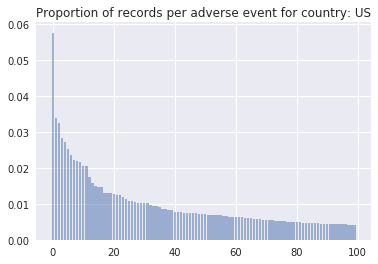

In [30]:
# Section 3: Focus on adverse event reporting for 5 key countries

# Number of records and proporton of records per adverse event: US (United States)
country_name = 'US'
n_records_per_adverse_event = get_n_records_per_adverse_event_for_country(country_name)
print(n_records_per_adverse_event)
count_proportion_bar_plot(n_records_per_adverse_event, country_name)

Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"GB"&count=patient.reaction.reactionmeddrapt.exact
                        adverse_event  count  count_proportion_GB
0                               DEATH  13330             0.049721
1                             MALAISE   8956             0.033406
2                             FATIGUE   7823             0.029180
3                            DYSPNOEA   7144             0.026647
4                              NAUSEA   6945             0.025905
5                           DIZZINESS   6461             0.024099
6                           DIARRHOEA   6374             0.023775
7                            HEADACHE   5933             0.022130
8                            VOMITING   5219             0.019467
9                    DRUG INTERACTION   5029             0.018758
10                               RASH   4596             0.017143
11                  CONFUSIO

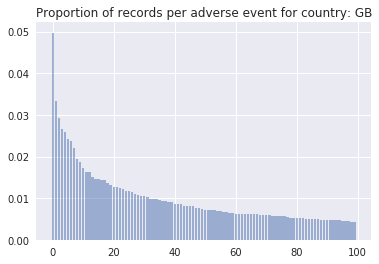

In [31]:
# Number of records and proporton of records per adverse event: GB (United Kingdom)
country_name = 'GB'
n_records_per_adverse_event = get_n_records_per_adverse_event_for_country(country_name)
print(n_records_per_adverse_event)
count_proportion_bar_plot(n_records_per_adverse_event, country_name)

Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"JP"&count=patient.reaction.reactionmeddrapt.exact
                                  adverse_event  count  count_proportion_JP
0                                       PYREXIA   5903             0.036566
1                     INTERSTITIAL LUNG DISEASE   4576             0.028346
2                      PLATELET COUNT DECREASED   4552             0.028197
3                                       ANAEMIA   4473             0.027708
4                                     PNEUMONIA   4098             0.025385
5                            DECREASED APPETITE   4069             0.025205
6                     HEPATIC FUNCTION ABNORMAL   3547             0.021972
7                                        NAUSEA   3469             0.021489
8                                     DIARRHOEA   3450             0.021371
9                              RENAL IMPAIRMENT   3416      

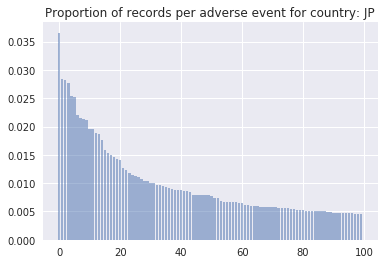

In [32]:
# Number of records and proporton of records per adverse event: Japan
country_name = 'JP'
n_records_per_adverse_event = get_n_records_per_adverse_event_for_country(country_name)
print(n_records_per_adverse_event)
count_proportion_bar_plot(n_records_per_adverse_event, country_name)

Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"GE"&count=patient.reaction.reactionmeddrapt.exact
                              adverse_event  count  count_proportion_GE
0                         HEPATIC CIRRHOSIS     38             0.119874
1                                     DEATH     18             0.056782
2                    PULMONARY TUBERCULOSIS     11             0.034700
3                                 PNEUMONIA      8             0.025237
4                                 HEPATITIS      8             0.025237
5                           HEPATIC FAILURE      8             0.025237
6                                   ASCITES      8             0.025237
7                            ENCEPHALOPATHY      7             0.022082
8                                  ASTHENIA      7             0.022082
9                             RENAL FAILURE      6             0.018927
10          OESOPHAGEAL VARI

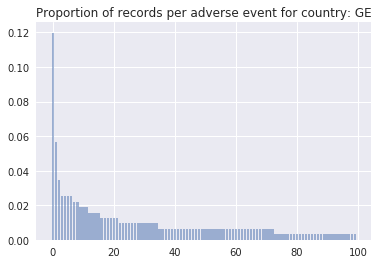

In [33]:
# Number of records and proporton of records per adverse event: Germany
country_name = 'GE'
n_records_per_adverse_event = get_n_records_per_adverse_event_for_country(country_name)
print(n_records_per_adverse_event)
count_proportion_bar_plot(n_records_per_adverse_event, country_name)

Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"CA"&count=patient.reaction.reactionmeddrapt.exact
                        adverse_event  count  count_proportion_CA
0                               DEATH   7867             0.040423
1                    DRUG INEFFECTIVE   7819             0.040177
2                             FATIGUE   6168             0.031693
3                              NAUSEA   5233             0.026889
4                            DYSPNOEA   4833             0.024834
5                                PAIN   4620             0.023739
6                           DIARRHOEA   4277             0.021977
7                             MALAISE   4263             0.021905
8                            HEADACHE   4112             0.021129
9                          ARTHRALGIA   4040             0.020759
10                          PNEUMONIA   3820             0.019628
11                      OFF 

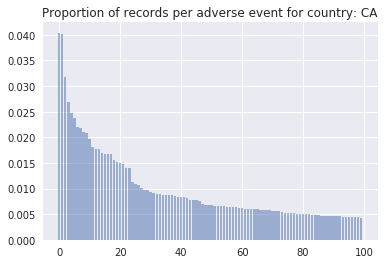

In [34]:
# Number of records and proporton of records per adverse event: Canada
country_name = 'CA'
n_records_per_adverse_event = get_n_records_per_adverse_event_for_country(country_name)
print(n_records_per_adverse_event)
count_proportion_bar_plot(n_records_per_adverse_event, country_name)

In [35]:
# Section 4: Compare adverse event reporting between 5 key countries

# Get record count and count proportion per adverse event as a dataframe for each country
country_codes = ['GB', 'JP', 'US', 'GE', 'CA']
n_records_per_adverse_event_by_country = []
for country_code in country_codes:
    n_records_per_adverse_event_by_country.append(get_n_records_per_adverse_event_for_country(country_code))

Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"GB"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"JP"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"US"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"GE"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+primarysource.reportercountry.exact:"CA"&count=patient.reaction.reactionmeddrapt.exact


In [36]:
adverse_events_pairs_plot = AdverseEventsByCountryPairsPlot(n_records_per_adverse_event_by_country).prepare_data()
adverse_events_pairs_plot.records_per_adverse_event_all

,adverse_event,count_proportion_GB,count_proportion_JP,count_proportion_US,count_proportion_GE,count_proportion_CA
0,DEATH,0.049721,0.018825,0.027181,0.056782,0.040423
1,MALAISE,0.033406,0.018652,0.020560,0.000000,0.021905
2,FATIGUE,0.029180,0.005600,0.032326,0.006309,0.031693
3,DYSPNOEA,0.026647,0.010785,0.022140,0.006309,0.024834
4,NAUSEA,0.025905,0.021489,0.033700,0.012618,0.026889
5,DIZZINESS,0.024099,0.010326,0.021715,0.000000,0.016920
6,DIARRHOEA,0.023775,0.021371,0.023654,0.000000,0.021977
7,HEADACHE,0.022130,0.007960,0.028198,0.009464,0.021129
8,VOMITING,0.019467,0.015276,0.017328,0.012618,0.017748
9,DRUG INTERACTION,0.018758,0.008424,0.000000,0.000000,0.004799


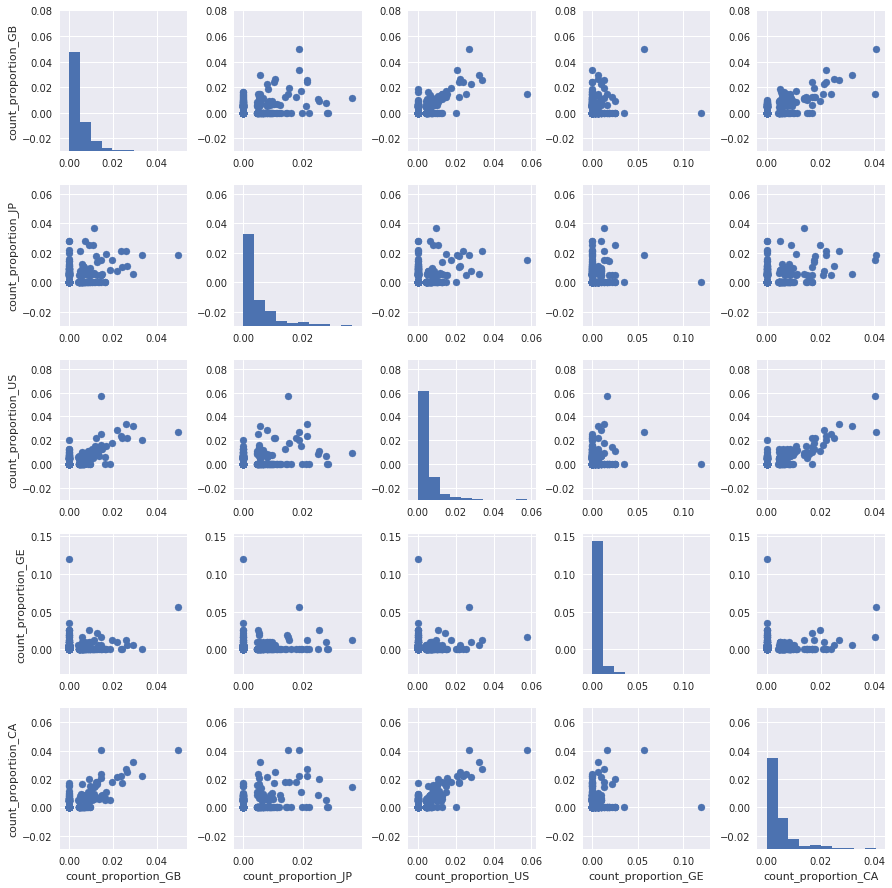

In [37]:
# Pair plot to compare record count proportion between countries
adverse_events_pairs_plot.plot()

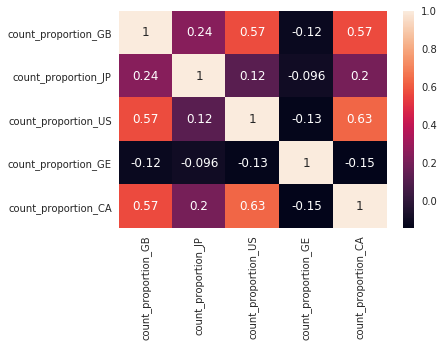

In [38]:
correlation_by_country = adverse_events_pairs_plot.records_per_adverse_event_all.corr(method = 'spearman')
seaborn.heatmap(correlation_by_country, annot=True)
plt.show()

In [39]:
# Section 5: Compare adverse event reporting between 5 key countries for the drug Simvastatin

# Get record count and count proportion per adverse event as a dataframe for each country
country_codes = ['GB', 'JP', 'US', 'GE', 'CA']
n_records_per_adverse_event_by_country = []
drug_name = 'SIMVASTATIN'
for country_code in country_codes:
    n_records_per_adverse_event_by_country.append(get_n_records_per_adverse_event_for_country_and_drug(country_code, drug_name))


Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:SIMVASTATIN+AND+primarysource.reportercountry.exact:"GB"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:SIMVASTATIN+AND+primarysource.reportercountry.exact:"JP"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:SIMVASTATIN+AND+primarysource.reportercountry.exact:"US"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:SIMVASTATIN+AND+primarysource.reportercountry.exact:"GE"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+pat

In [40]:
adverse_events_pairs_plot = AdverseEventsByCountryPairsPlot(n_records_per_adverse_event_by_country).prepare_data()
adverse_events_pairs_plot.records_per_adverse_event_all

,adverse_event,count_proportion_GB,count_proportion_JP,count_proportion_US,count_proportion_GE,count_proportion_CA
0,MYALGIA,0.046966,0.007273,0.010313,0.000000,0.009077
1,FATIGUE,0.035743,0.000000,0.032347,0.000000,0.037065
2,MALAISE,0.028479,0.014545,0.015601,0.000000,0.019667
3,DRUG INTERACTION,0.026711,0.010909,0.005907,0.000000,0.006051
4,DYSPNOEA,0.025866,0.010909,0.028033,0.000000,0.025719
5,PAIN IN EXTREMITY,0.023406,0.007273,0.016529,0.000000,0.018911
6,ARTHRALGIA,0.022445,0.010909,0.013870,0.000000,0.031770
7,DIARRHOEA,0.020946,0.021818,0.028945,0.000000,0.029501
8,DIZZINESS,0.020754,0.018182,0.024028,0.000000,0.014372
9,CONFUSIONAL STATE,0.018102,0.000000,0.007638,0.000000,0.000000


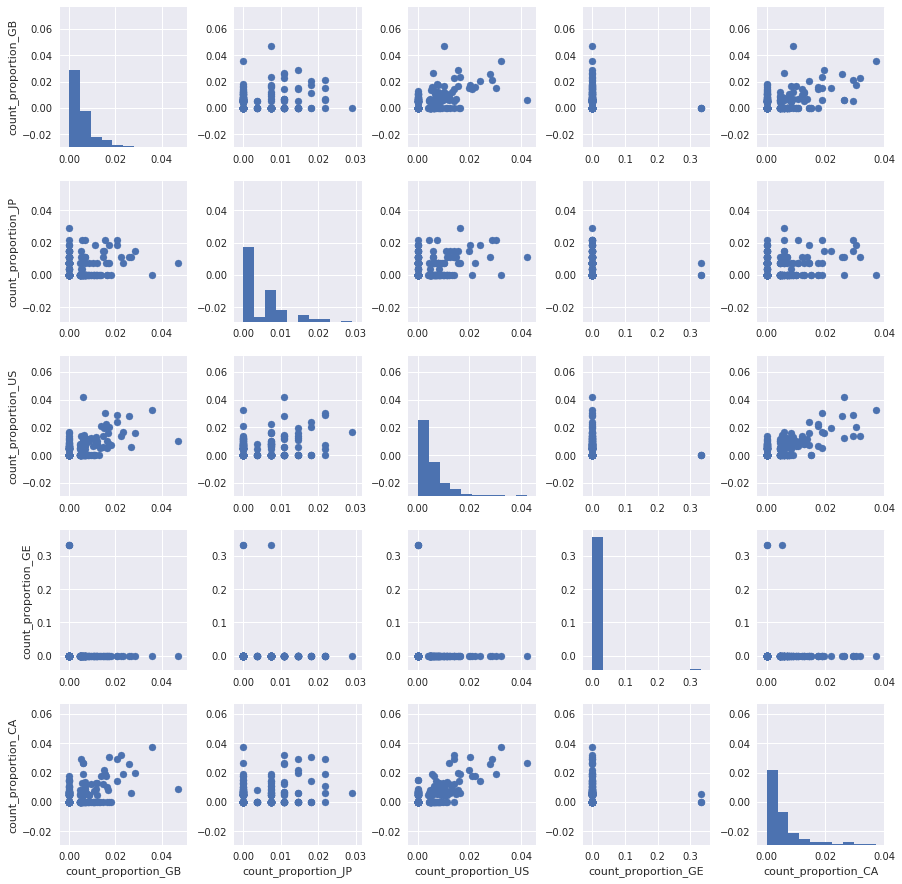

In [41]:
adverse_events_pairs_plot.plot()

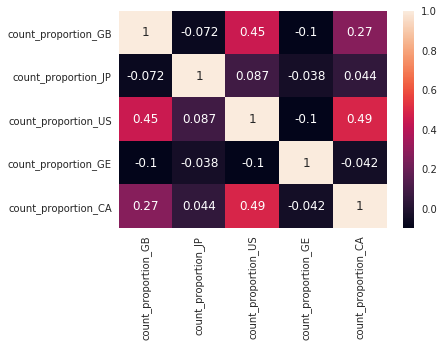

In [42]:
correlation_by_country = adverse_events_pairs_plot.records_per_adverse_event_all.corr(method = 'spearman')
seaborn.heatmap(correlation_by_country, annot=True)
plt.show()

In [43]:
# Section 6: Compare adverse event reporting between 5 key countries for the drug Paracetamol (Acetaminophen)

# Get record count and count proportion per adverse event as a dataframe for each country
country_codes = ['GB', 'JP', 'US', 'CA']
n_records_per_adverse_event_by_country = []
drug_name = 'PARACETAMOL'
for country_code in country_codes:
    n_records_per_adverse_event_by_country.append(get_n_records_per_adverse_event_for_country_and_drug(country_code, drug_name))

Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:PARACETAMOL+AND+primarysource.reportercountry.exact:"GB"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:PARACETAMOL+AND+primarysource.reportercountry.exact:"JP"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:PARACETAMOL+AND+primarysource.reportercountry.exact:"US"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:PARACETAMOL+AND+primarysource.reportercountry.exact:"CA"&count=patient.reaction.reactionmeddrapt.exact


In [44]:
adverse_events_pairs_plot = AdverseEventsByCountryPairsPlot(n_records_per_adverse_event_by_country).prepare_data()
adverse_events_pairs_plot.records_per_adverse_event_all

,adverse_event,count_proportion_GB,count_proportion_JP,count_proportion_US,count_proportion_CA
0,MALAISE,0.030994,0.005597,0.009091,0.007595
1,DIZZINESS,0.028154,0.009328,0.013636,0.018987
2,DYSPNOEA,0.028114,0.009328,0.018103,0.015190
3,NAUSEA,0.027830,0.014925,0.030329,0.017722
4,CONFUSIONAL STATE,0.027465,0.000000,0.006740,0.005063
5,VOMITING,0.025517,0.011194,0.019984,0.024051
6,DIARRHOEA,0.023002,0.018657,0.022100,0.015190
7,FATIGUE,0.022840,0.000000,0.026332,0.026582
8,HEADACHE,0.020041,0.018657,0.023276,0.018987
9,ACUTE KIDNEY INJURY,0.018458,0.013060,0.000000,0.000000


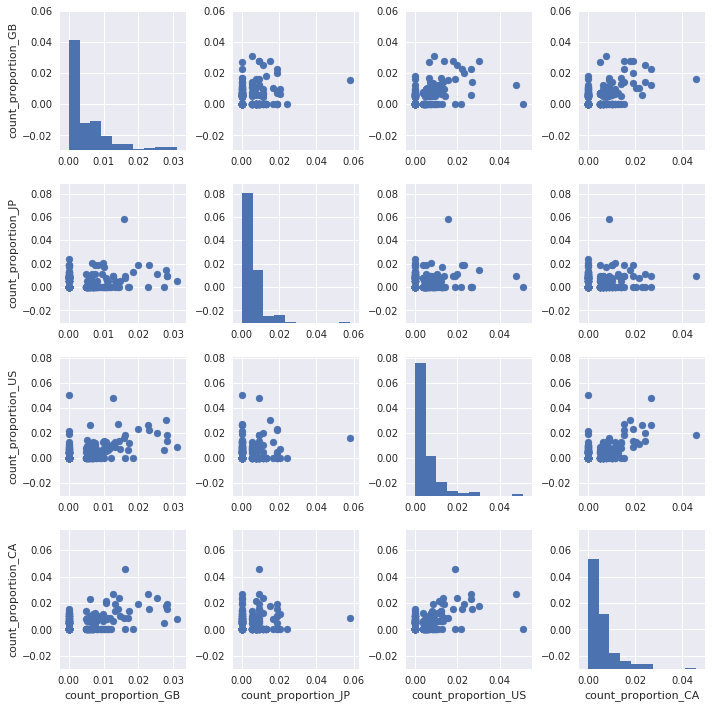

In [45]:
adverse_events_pairs_plot.plot()

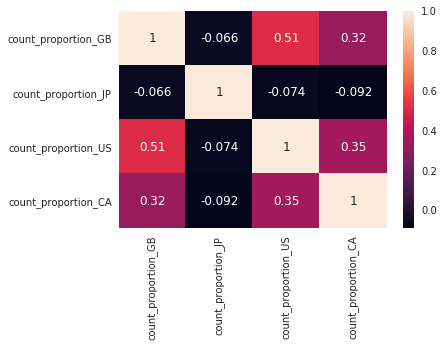

In [46]:
correlation_by_country = adverse_events_pairs_plot.records_per_adverse_event_all.corr(method = 'spearman')
seaborn.heatmap(correlation_by_country, annot=True)
plt.show()

In [47]:
# Get record count and count proportion per adverse event as a dataframe for each country
country_codes = ['GB', 'JP', 'US', 'CA']
n_records_per_adverse_event_by_country = []
drug_name = 'ACETAMINOPHEN'
for country_code in country_codes:
    n_records_per_adverse_event_by_country.append(get_n_records_per_adverse_event_for_country_and_drug(country_code, drug_name))


Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:ACETAMINOPHEN+AND+primarysource.reportercountry.exact:"GB"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:ACETAMINOPHEN+AND+primarysource.reportercountry.exact:"JP"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:ACETAMINOPHEN+AND+primarysource.reportercountry.exact:"US"&count=patient.reaction.reactionmeddrapt.exact
Query url: https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20171006]+AND+patient.drug.medicinalproduct:ACETAMINOPHEN+AND+primarysource.reportercountry.exact:"CA"&count=patient.reaction.reactionmeddrapt.exact


In [48]:
adverse_events_pairs_plot = AdverseEventsByCountryPairsPlot(n_records_per_adverse_event_by_country).prepare_data()
adverse_events_pairs_plot.records_per_adverse_event_all

,adverse_event,count_proportion_GB,count_proportion_JP,count_proportion_US,count_proportion_CA
0,OVERDOSE,0.071547,0.005191,0.008974,0.009854
1,ACUTE HEPATIC FAILURE,0.051734,0.000000,0.000000,0.000000
2,DEATH,0.031921,0.007138,0.036415,0.008685
3,FATIGUE,0.028068,0.000000,0.025384,0.033570
4,VOMITING,0.027518,0.018170,0.016931,0.013695
5,TOXICITY TO VARIOUS AGENTS,0.020914,0.005840,0.039402,0.008434
6,MALAISE,0.020914,0.007787,0.011737,0.013111
7,NAUSEA,0.020363,0.015574,0.027949,0.021294
8,HEADACHE,0.020363,0.005840,0.022818,0.022380
9,DIARRHOEA,0.019813,0.017521,0.018939,0.018372


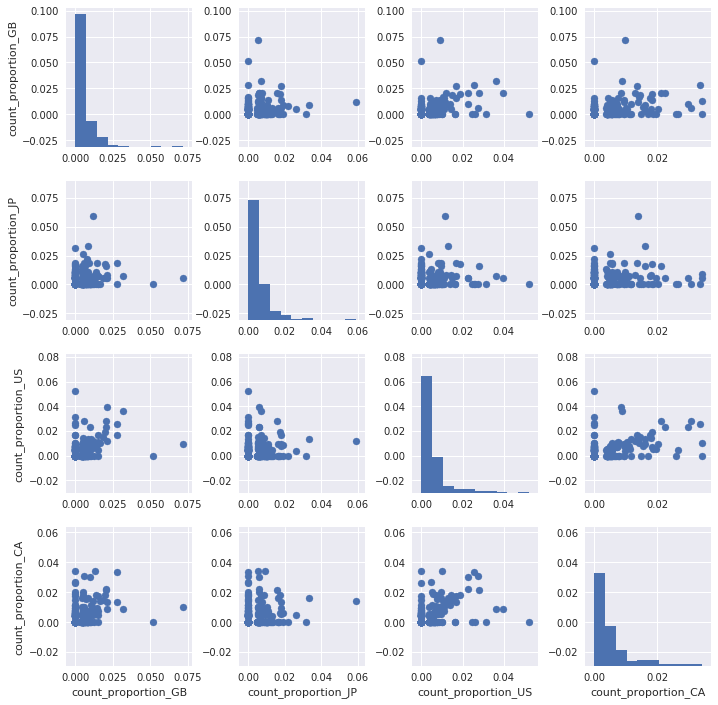

In [49]:
# Pairs plot
adverse_events_pairs_plot.plot()

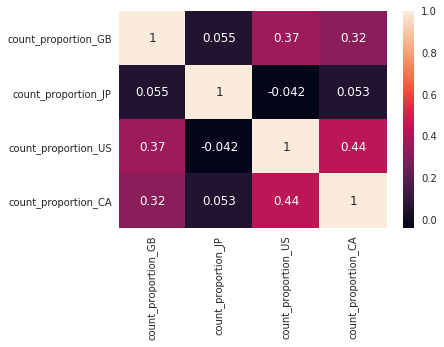

In [50]:
correlation_by_country = adverse_events_pairs_plot.records_per_adverse_event_all.corr(method = 'spearman')
seaborn.heatmap(correlation_by_country, annot=True)
plt.show()